In [1]:
%matplotlib inline
%run '../../comet-test/bin/notebook_utils.py'
#%run 'bin/plot_utilization.py'
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Expand the notebook to the width of the browser
plt.style.use('ggplot')

In [2]:
! radical-stack


  python               : 3.6.10
  pythonpath           : 
  virtualenv           : conda-parsl

  radical.analytics    : 1.5.0
  radical.gtod         : 1.5.0
  radical.pilot        : 1.5.2
  radical.saga         : 1.5.2
  radical.utils        : 1.5.2



In [3]:
suds = ['parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0008',
        'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0009',
        'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0010',
        'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0011',
        'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018558.0001']

sdir = '../../../../RADICAL/radical.pilot/examples/parsl/WS/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': int(ss[sid]['ncores']/24)})

In [6]:
info = []

for sid in suds:
   
    u  = ss[sid]['u']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p.duration(event=[  {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p.duration(event=[  {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_u': u.duration(event=[  {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p.duration(event=[  {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE        },
                                   [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
        
      'pilot_lifetime': p.duration(event=[{ru.EVENT: 'bootstrap_0_start', ru.STATE: None},
                                          {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None}])})
    u.timestamps
    p.timestamps
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})
    info.append({'session':sid,
                  'resource' : ss[sid]['pres'],
                  'pilot_lm' : ss[sid]['lm'], 
                  'pilots'   : ss[sid]['npilot'],
                  'ps_active': ss[sid]['npact'],
                  'cores'    : ss[sid]['ncores'],
                  'gpus'     : ss[sid]['ngpus'], 
                  'nodes'    : ss[sid]['nnodes'], 
                  'tasks'    : ss[sid]['nunit'], 
                  'ts_done'  : ss[sid]['nunit']-ss[sid]['nufail'],  
                  'ts_failed': ss[sid]['nufail'],
                  'Pilot life time':ss[sid]['pilot_lifetime'],
                  'Pilot TTX':ss[sid]['ttx_p'],
                  'Unit TTX':ss[sid]['ttx_u'],
                  'RCT overheads':ss[sid]['ovh_rtc']})
df_info = pd.DataFrame(info) 
df_info

,session,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed,Pilot life time,Pilot TTX,Unit TTX,RCT overheads
0,parsl.radical_executor.session.js-17-185.jetst...,xsede.comet_ssh,SSH,1,1,24,0,1,24,24,0,372.0,328.976879,302.0,26.976879
1,parsl.radical_executor.session.js-17-185.jetst...,xsede.comet_ssh,SSH,1,1,48,0,2,48,48,0,356.0,334.719178,303.0,31.719178
2,parsl.radical_executor.session.js-17-185.jetst...,xsede.comet_ssh,SSH,1,1,432,0,18,432,431,1,424.0,369.420641,331.0,38.420641
3,parsl.radical_executor.session.js-17-185.jetst...,xsede.comet_ssh,SSH,1,1,864,0,36,864,861,3,417.0,374.952374,344.0,30.952374
4,parsl.radical_executor.session.js-17-185.jetst...,xsede.comet_ssh,SSH,1,1,1728,0,72,1728,1716,12,451.0,405.832887,371.0,34.832887


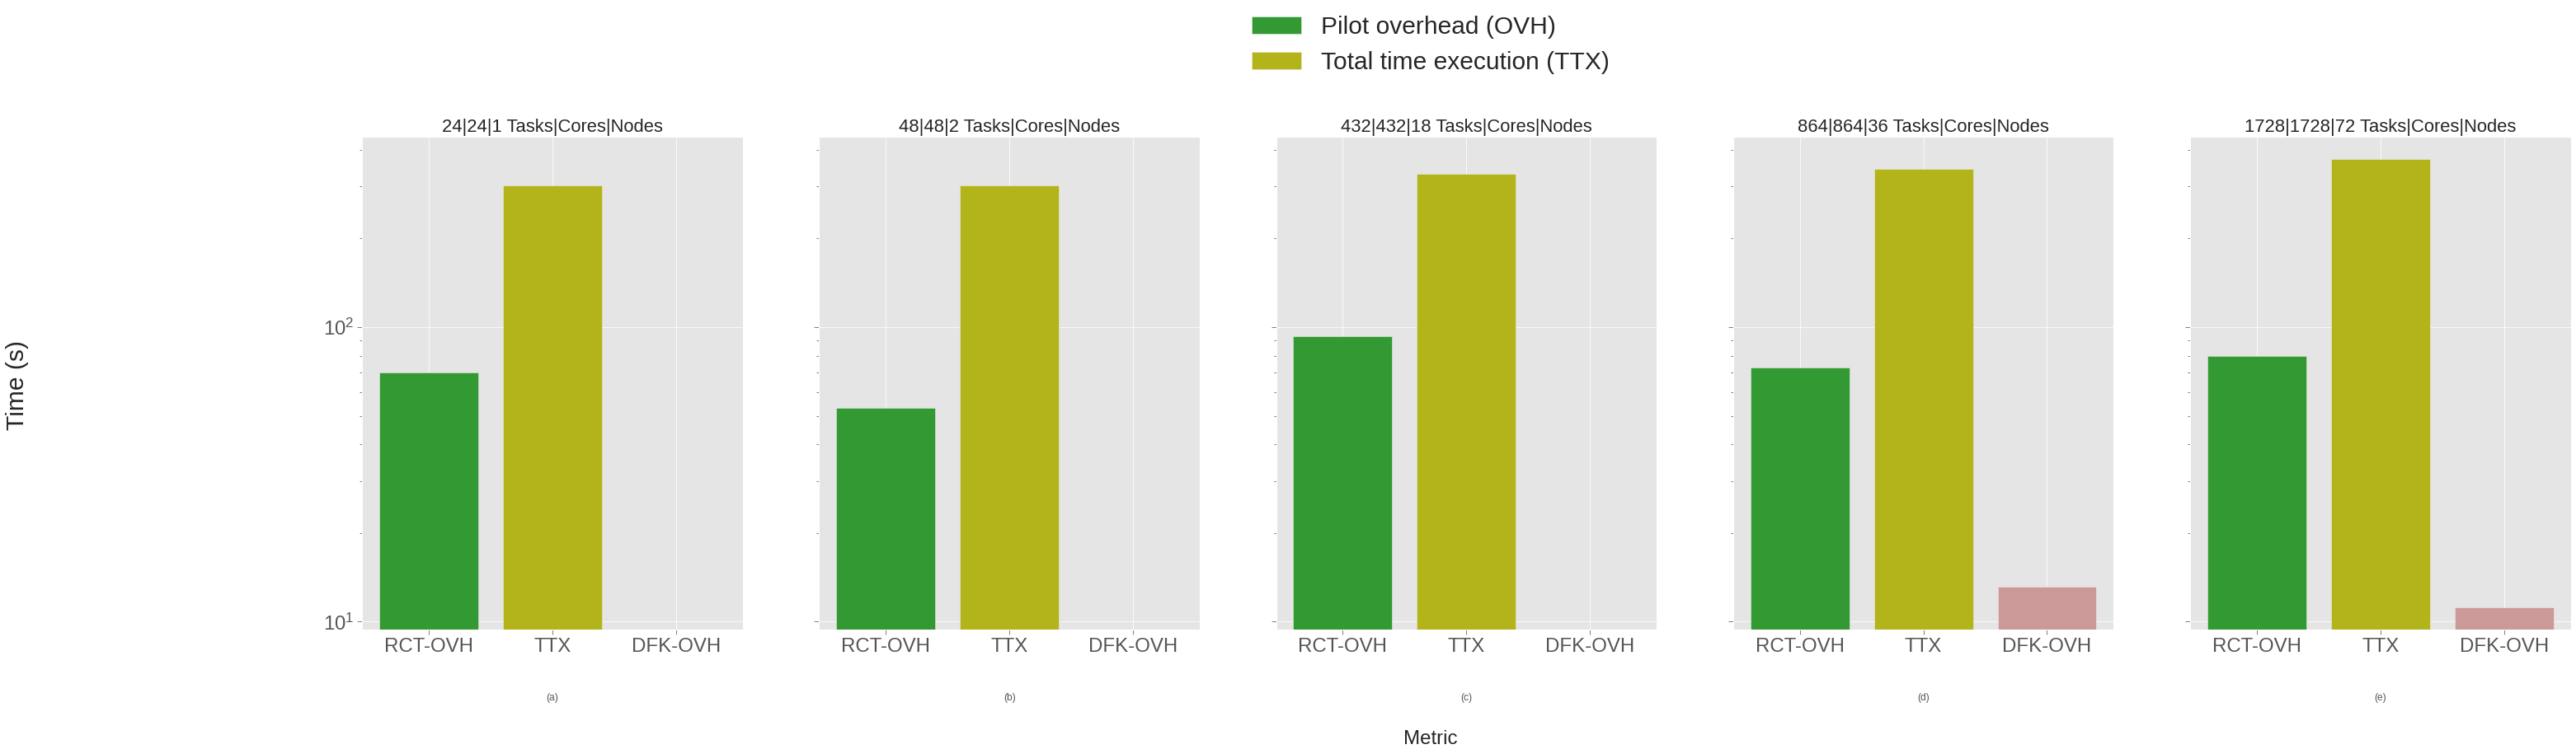

In [7]:
fwidth = 48
fhight = 11
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

dfk_ovh = {'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0008':{'time':3.012},
           'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0009':{'time':3.5},
           'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0010':{'time':5.102},
           'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018557.0011':{'time':13.13},
           'parsl.radical_executor.session.js-17-185.jetstream-cloud.org.aymen.018558.0001':{'time':11.181}
          }


i = 0
j = 'a'
for sid in suds:
    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.set_title('%s|%s|%s Tasks|Cores|Nodes' % (ss[sid]['nunit'],ss[sid]['ncores'], int(ss[sid]['nnodes'])),fontsize= 22)

    ax.bar(x = 'RCT-OVH', height = ss[sid]['pilot_lifetime']-ss[sid]['ttx_u'], color = tableau20[4], log=True)
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[14], log = True)
    ax.bar(x = 'DFK-OVH',height = dfk_ovh[sid]['time']  , color = tableau20[11], log=True)

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(0,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=30)
fig.text( 0.5, -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['Pilot overhead (OVH)', 'Total time execution (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.5, 1.1), fontsize=30, ncol=1)
#plt.savefig('../figures/rp_ss_plt_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../figures/integ_ws_ttx_ovh.pdf', dpi=300, bbox_inches='tight')